# Sliding Window Approaches to Spectral Estimation

Aperiodic activity is known to fluctuate not only with brain state, but also likely exhibits event-related modulation. Time-resolved methods for spectral parameterization might be desirable for researchers investigating highly time-sensitive or event-related changes in aperiodic activity. 

### Issue

There are few easily accessible methods available for estimating aperiodic activity on an event-locked basis, with the notable exception of Spectral Parameterization Resolved in Time (SPRiNT), which is a Matlab-based package [see Wilson et al 2022].

### Solution

The SpecParam tool can be used to generate successive, windowed estimates of spectral parameters, which can then be analyzed in a similar manner as event-related periodic changes might be.

### Related Work

The following papers include discussion of this topic:

- [Time-resolved parameterization of aperiodic and periodic brain activity](https://elifesciences.org/articles/77348#abstract), Wilson et al, 2022

### Related Discussion / Examples

The following examples discuss related topics:
-  [LINK](LINK), DESCRIPTION

### Imports

In [1]:
# Imports
# Standard python libraries
import numpy as np
import scipy.io as sio

# Neurodsp libraries
from neurodsp import spectral

# SpecParam (FOOOF) libraries 
from fooof import FOOOF, FOOOFGroup
from fooof.analysis import get_band_peak_fm, get_band_peak_fg

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

### Load Data

In [2]:
# We are setting the sampling frequency here. The data is sampled at 1000 Hz.
fs = 1000 

# Load the channel and the event indices.
data = sio.loadmat('../data/ecog_data.mat', squeeze_me=True)
sta = data['sta'] # Standard event
tar = data['tar'] # Target event
resp = data['resp'] # Response times
data = data['data'] # Neural data from one ECoG channel
times = np.arange(len(data))/fs

### Inspect the raw data, PSD (<60 Hz), and initial FOOOF fit

In [3]:
# Get a sense of the shape of these arrays, and their content
print(data.shape)
print(tar.shape)
print(sta.shape)
print('\nFirst few target events: ', end='')
print(tar[:10])

(1459920,)
(117,)
(380,)

First few target events: [370021 373387 378106 381964 384115 398071 399946 406863 408338 411489]


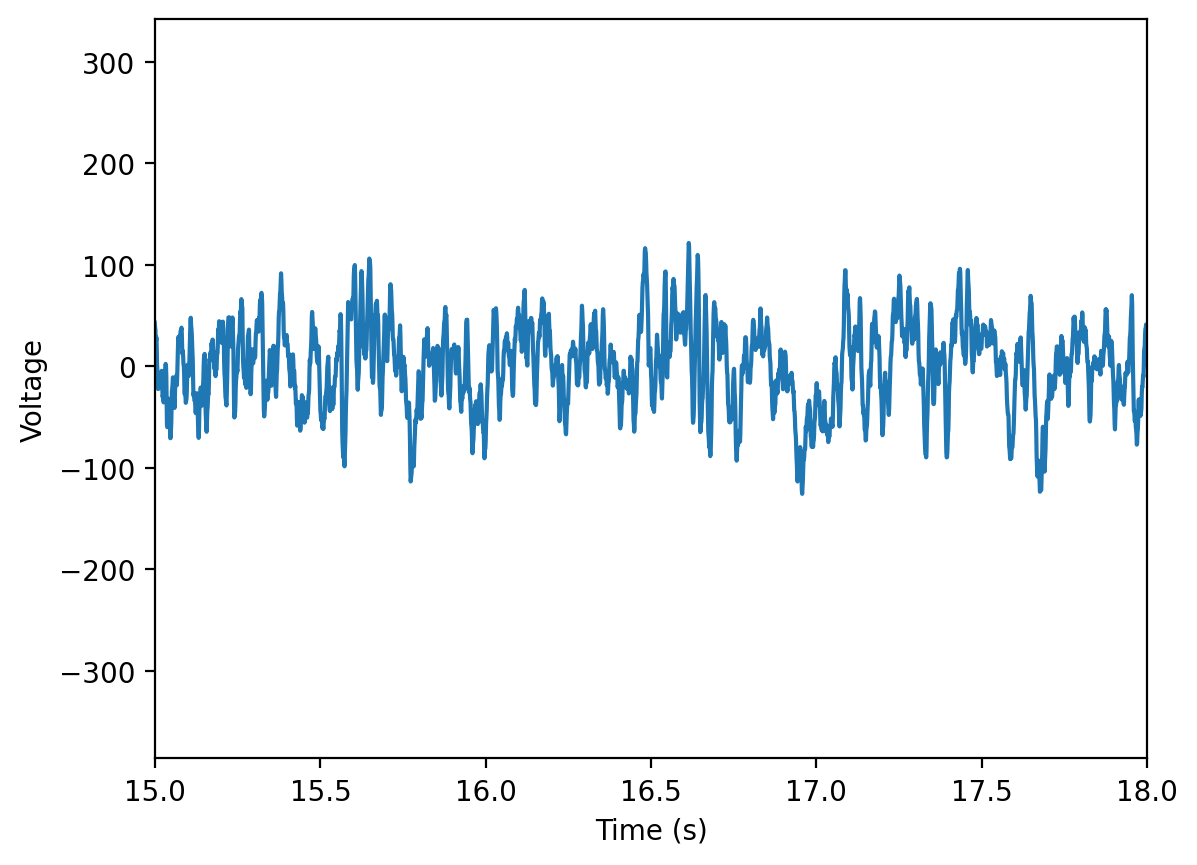

In [4]:
# Plot a section of the data in the time domain.
plt.plot(times, data)
plt.xlim((15,18))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

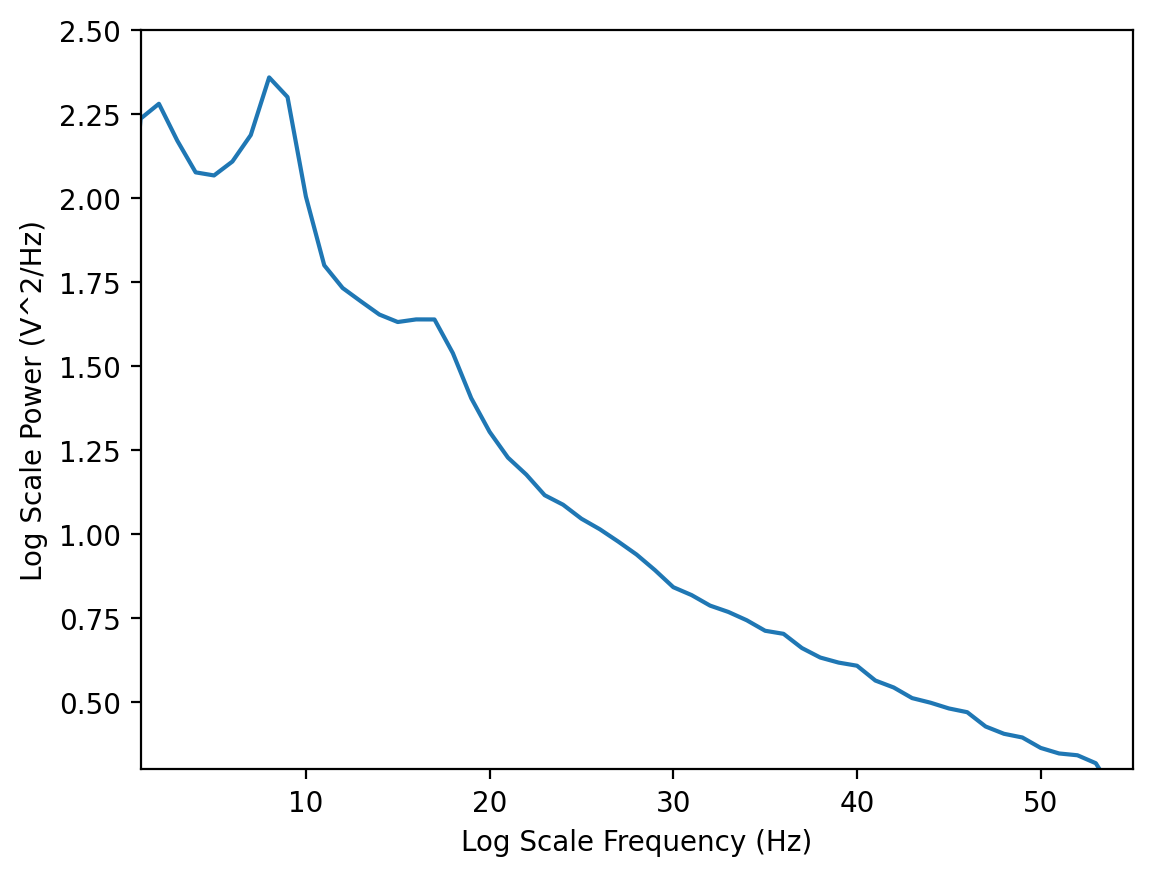

In [5]:
# Compute power spectrum
freq, psd = spectral.compute_spectrum(data, fs=fs, method='welch', window='hann')

# Plot with log scaling the power, zoom in below 60 Hz, and log scale the frequency axis
plt.plot(freq, np.log10(psd))
plt.xlabel('Log Scale Frequency (Hz)')
plt.ylabel('Log Scale Power (V^2/Hz)')
plt.xlim((1, 55))
plt.ylim((0.3, 2.5))
plt.show()

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 1 - 40 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     4.6699, 287.0261, 2.5553                                     
                                                                                                  
                                       2 peaks were found:                                        
          

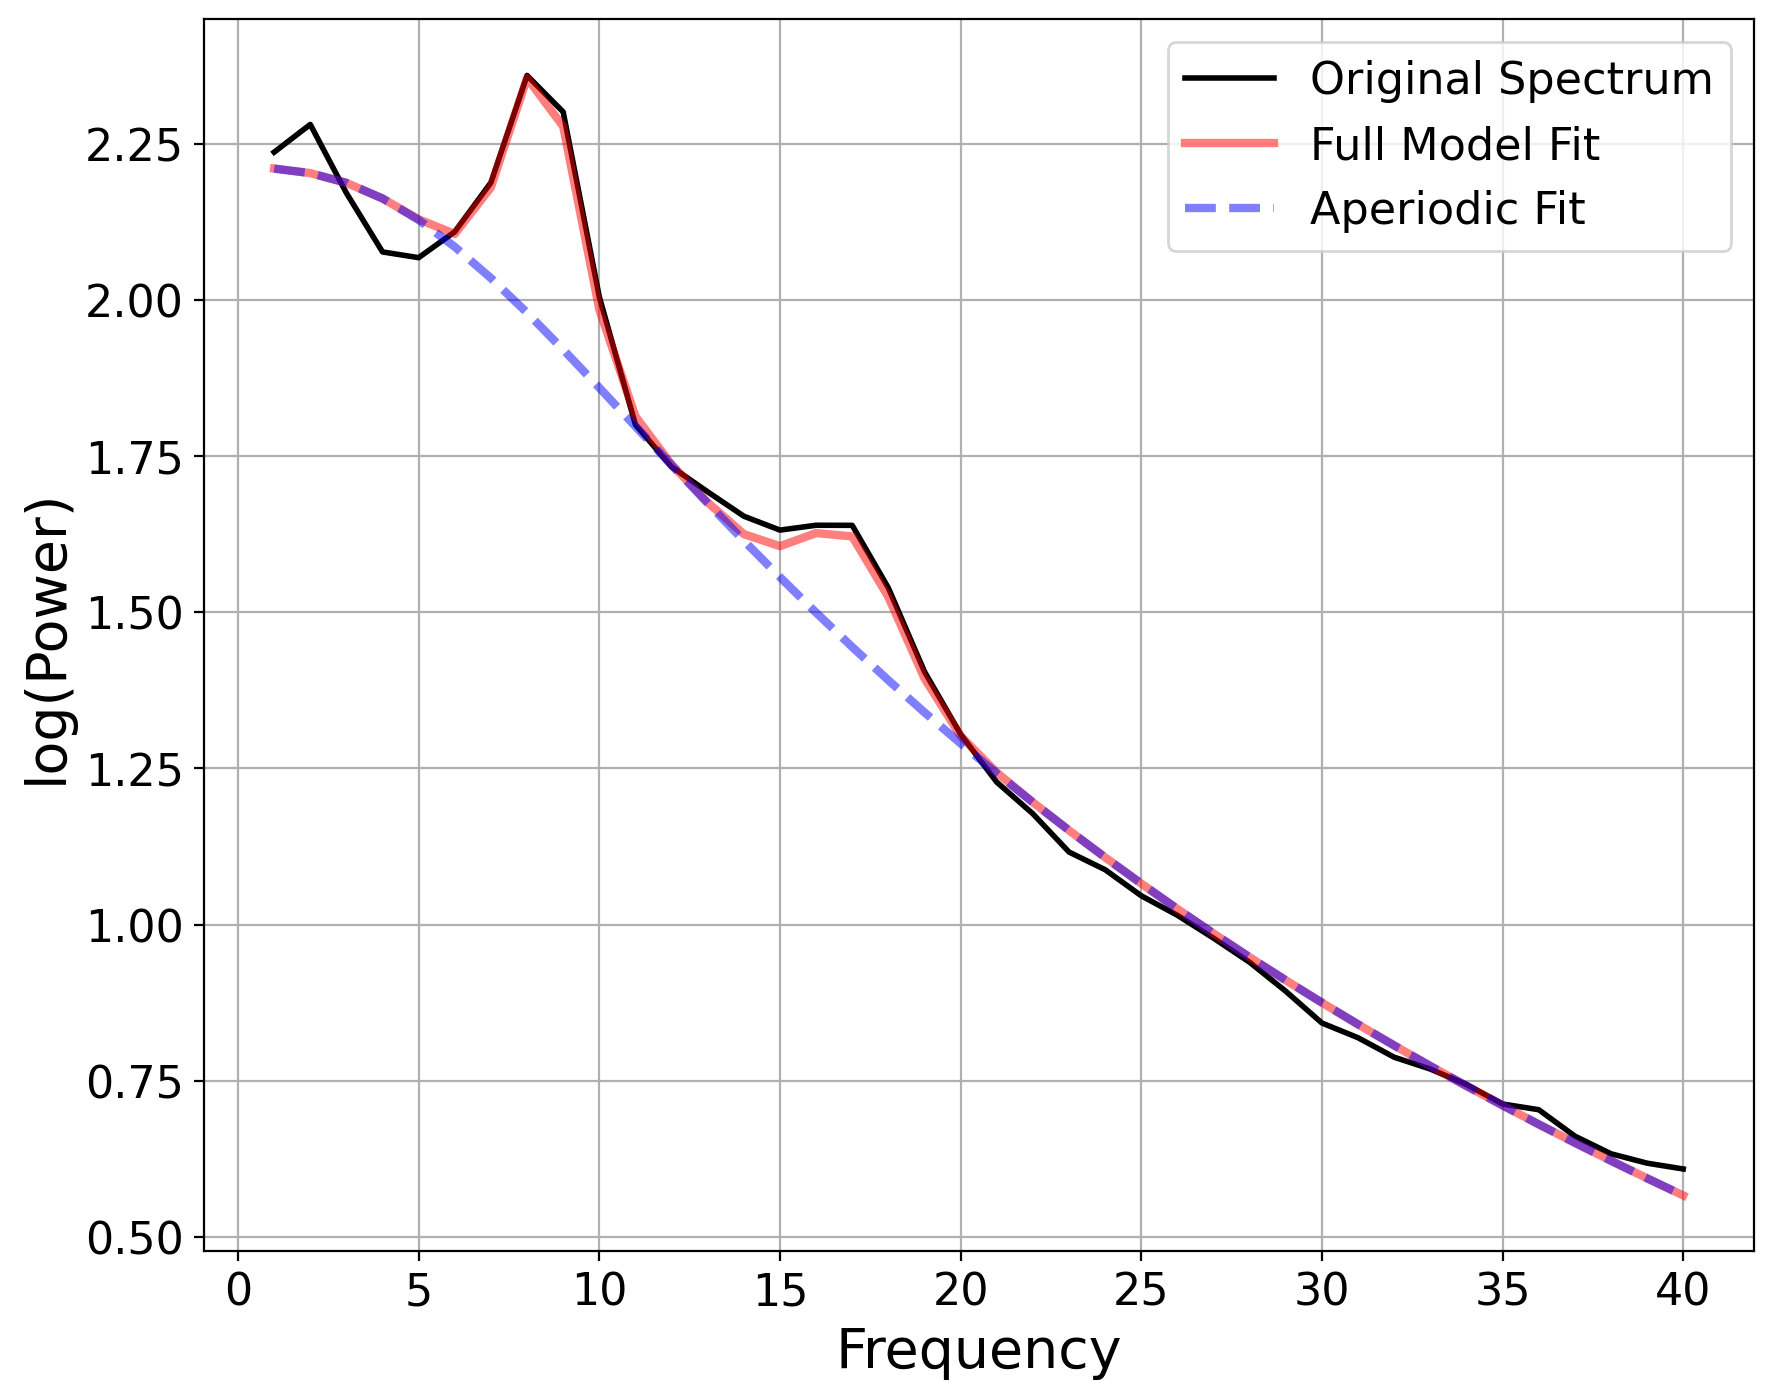

In [6]:
# In this case, we set a peak width limit to be higher than 2 frequencies wide AND smaller than 8 frequencies wide.
# Furthermore, we're setting a hard threshold minimum for the peak height to be considered an oscillation.
specparam_sets = {'peak_width_limits': [2, 8], 'min_peak_height': 0.1, 'aperiodic_mode':'knee'}
freq_range = [1, 40] # Depending on the quality of your data, you might not want to fit very high frequencies

# Define the frequency ranges you consider to be alpha oscillations
alpha_range = [8, 12]

# Initialize models
model = FOOOF(**specparam_sets)

# Fit models
model.fit(freq, psd, freq_range=freq_range)
model.report()

A spectral estimation across the whole length of the data yields us these three parameters describing the time-invariant aperiodic activity: an offset, an exponent, and a knee parameter. 

However, this dataset contains task-relevant events. In analyzing this data, you might want to know more about whether these parameters are modulated by task events, and if so, whether event-related aperiodic changes relate to behaviorally or cognitively interesting factors (as is typical in periodic analyses). 

One way to do so would be to select one time window prior to the stimulus onset, and another time window after stimulus onset, and compare the parameters between these. The details and implementation of this method is outlined in another notebook in this repository (XX-- fill in name of notebook that Andrew is working on).

An alternative method yields higher temporal resolution of event-locked aperiodic changes that may be obscured by computing spectral power over one large time window, or by trial-averaging in the time domain prior to aperiodic model fitting. To get time-resolved estimations of spectral parameters, we can use a sliding window approach to estimating and fitting aperiodic activity. This entails selecting out windows of time, deriving an aperiodic model fit, and sliding forward in time to repeat the process-- the end result being an array of aperiodic parameters calculated at N sequential time points. 

### Deriving Sliding Window Aperiodic Model Fits

First, let's define a window of time around the event onset which we will subselect our data from

In [7]:
time_around_event = (-2000,2000) # in ms

Next, let's define the length of the time window that we are sliding across the data, as well as the overlap between successive windows

In [8]:
len_win = 1000 # in ms
t_overlap = 500 # in ms

The choice in window length is not arbitrary; factors that influence the specific window of choice include the desired frequency range of interest, the timing of the task events themselves, and the total length of the task epoch that you are sliding across. 

For analyses dependent on accurate estimates of low frequency activity, you might want to use longer time windows. The lower bounds of the frequencies that you can estimate will be constrained by the length of your time window (as is true in any spectral estimation). For example, if you are interested in 2Hz (delta range) activity, you need at least two seconds of data to resolve a maximum of one delta cycle. Examples of analyses where low frequency activity as it is captured by the aperiodic signal might be particularly interesting include analyses focused on neural timescales, or for the aperiodic correction of low frequency oscillations. 

Other analyses might allow or even necessitate shorter time windows; for example if your task event is very brief, it may blur aperiodic changes in the time domain too much to have long or highly overlapping time windows. 

Now that we've selected our time window bounds, let's construct a function that will extract "trials" of event data.

In [9]:
def event_related(data, fs, indices, window, subtract_mean=None):
    """Take an input time series, vector of event indices, and window sizes,
    and return a 2d matrix of windowed trials around the event indices.
    
    Parameters
    ----------
    data : array-like 1d
        Voltage time series
    data : float
        Data sampling rate (Hz)
    indices : array-like 1d of integers
        Indices of event onset indices
    window : tuple (intengers)
        Window (in ms) around event onsets
    subtract_mean : tuple (intengers), optional
        if present, subtract the mean value in the subtract_mean window for each
        trial from that trial's time series (this is a trial-by-trial baseline)
    
    Returns
    -------
    event_related_matrix : array-like 2d
        Event-related times series around each index
        Each row is a separate event
    """
    
    # convert times (in ms) to indices of points along the array
    def windows_to_indices(fs, window_times):
        conversion_factor = (1/fs)*1000 # convert from time points to ms
        window_times = np.floor(np.asarray(window_times)/conversion_factor) # convert
        window_times = window_times.astype(int) # turn to ints
        
        return window_times
    
    window_idx = windows_to_indices(fs, window) # convert times (in ms) to indices
    inds = indices + np.arange(window_idx[0],window_idx[1])[:,None] # build matrix of indices
    event_times = np.arange(window[0], window[1], fs/1000)
    
    event_related_matrix = data[inds] # grab the data
    event_related_matrix = np.squeeze(event_related_matrix).T # make sure it's in the right format
    
    # baseline, if requested
    if subtract_mean is not None:
        basewin = [0,0]
        basewin[0] = np.argmin(np.abs(event_times-subtract_mean[0]))
        basewin[1] = np.argmin(np.abs(event_times-subtract_mean[1]))
        event_related_matrix = event_related_matrix - event_related_matrix[:, basewin[0]:basewin[1]].mean(axis=1, keepdims=True)
    
    return event_times, event_related_matrix

(For now, we will collapse across task condition)

In [10]:
event_times, event_related_matrix = event_related(data, fs, indices=np.concatenate([tar,sta]), window=(time_around_event), subtract_mean=(time_around_event[0],0))

print(event_times.shape)
print(event_related_matrix.shape)

(4000,)
(497, 4000)


In [11]:
event_times.shape

(4000,)

Now we have an array of shape n_events x n_times

Let's construct another function that averages across these events to get an ERP over the whole event time period, and drags our time window across the ERP in the specified timesteps to generate aperiodic fits at every point. 

In [22]:
def dynamic_fooof_fits(data_matrix, times, event_range, fs, window_length, t_overlap, freq_range, specparam_settings, average_trials=1, report=1):

    # get the start of each time window
    time_steps = np.arange(event_range[0], event_range[1], (window_length-t_overlap))
    # get the start and end of each time window, if it fits within the whole signal length
    time_steps = [(t, t+window_length) for t in time_steps if (t+window_length <= event_range[1])]

    # for each time step, extract the data of that time range out for every trial and average across trials if it is specified by user
    trial_subsets = np.zeros((len(time_steps), data_matrix.shape[0], int((window_length/1000)*fs))) # shape n_time steps, n events, n samples
    print(trial_subsets.shape)
    for i, win in enumerate(time_steps):
        print(win)
        subset_data = data_matrix[:, ((times>=win[0]) & (times<win[1]))] # should be shape n events, n samples (in this time window)
        trial_subsets[i,:,:] = subset_data

    fooof_groups_out = []
    psds = []
    if average_trials:
        trial_subsets = trial_subsets.mean(axis=1) # will end up being shape n time steps, n samples

        # Compute power spectrum -- takes data in 2D array
        freq, psd = spectral.compute_spectrum(trial_subsets, fs=fs, method='welch', window='hann')
        # psd here will be shape (n time windows, n freqs)
       
        trial_subsets_model = FOOOFGroup(**specparam_settings)
        trial_subsets_model.fit(freq, psd, freq_range=freq_range)
        if report:
            trial_subsets_model.report()
        fooof_groups_out.append(trial_subsets_model)
        psds.append(psd)
    else:
        # if we're not averaging across trial, we want to loop through every timestep and calculate the PSD and FOOOF on each set of trials for every timestep
        # this may take a long while depending on how many trials and how many timesteps you have (because it will run [n time steps X n trials] times)
        for i in range(len(time_steps)):
            data_this_win = trial_subsets[i,:,:]

            # Compute power spectrum -- takes data in 2D array
            freq, psd = spectral.compute_spectrum(data_this_win, fs=fs, method='welch', window='hann')
            # psd is shape (n trials, n freqs)
        
            trial_subsets_model = FOOOFGroup(**specparam_settings)
            trial_subsets_model.fit(freq, psd, freq_range=freq_range)
            if report:
                trial_subsets_model.report()
            fooof_groups_out.append(trial_subsets_model)
            psds.append(psd)
                         

    return freq, psds, fooof_groups_out

In [23]:
freqs, powers_list, groups_list = dynamic_fooof_fits(data_matrix=event_related_matrix, times=event_times, event_range=time_around_event, fs=fs, window_length=len_win, t_overlap=t_overlap, 
                              freq_range=[0,40], specparam_settings=specparam_sets,
                              average_trials=1, report=0)

(7, 497, 1000)
(-2000, -1000)
(-1500, -500)
(-1000, 0)
(-500, 500)
(0, 1000)
(500, 1500)
(1000, 2000)

FOOOF WARNING: Skipping frequency == 0, as this causes a problem with fitting.
Running FOOOFGroup across 7 power spectra.


c:\Users\dillc\anaconda3\envs\aperiodicMethods\Lib\site-packages\fooof\core\funcs.py:67: RuntimeWarning: invalid value encountered in log10
  ys = ys + offset - np.log10(knee + xs**exp)


In [27]:
print(len(powers_list))
print(powers_list[0].shape) # shape N timesteps, N freqs

1
(7, 501)


In [26]:
len(groups_list)

1

### SECTION II TITLE

In [72]:
500/1000*1000

500.0

### Conclusion

<>